# ----------------------Movie Analytics and Recommender System-----------------------

# Problem Statement

# ----------------------------------------------------------------------------------------------------------

Nowadays, there is a vast collection of movies available on various platforms. It can be challenging for users to find movies that match their preferences. So to personalize the movie experience and to increase the engagement of the users with the platform, which will also help the platform to improve its revenue generation in the present competitive environment , a recommendation system is preferred. Given a dataset of movies with their features, the goal of our recommendation system is to suggest movies to users based on their preferences.

# Architecture

# ----------------------------------------------------------------------------------------------------------

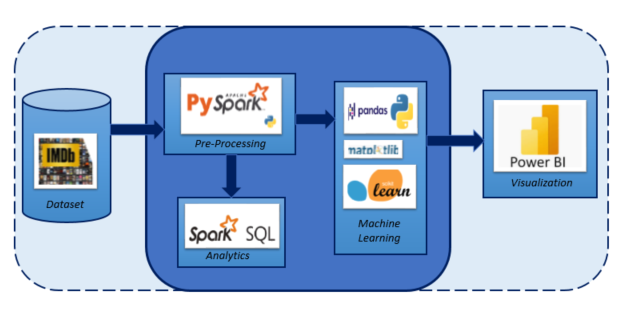

# Installing PySpark

# ----------------------------------------------------------------------------------------------------------

In [1]:
!pip install pyspark py4j

Defaulting to user installation because normal site-packages is not writeable


# Importing SparkSession and Other Libraries

# ----------------------------------------------------------------------------------------------------------

In [2]:
# importing SparkSession
from pyspark.sql import SparkSession

# importing pyspark libraries
from pyspark.sql import functions as F
from pyspark.sql.functions import col, isnan, when, count

# importing python libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Creating SparkSession

# ----------------------------------------------------------------------------------------------------------

In [3]:
# Create a SparkSession
spark=SparkSession.builder.appName("Jupyter Notebook").getOrCreate() 

In [4]:
# Checking version of the spark
spark

# Importing IMDB DataSet : 4 tsv files

# ----------------------------------------------------------------------------------------------------------

### principal.tsv

1. principal.tsv : Contains the principal cast/crew for titles
    tconst (string) - alphanumeric unique identifier of the title
    ordering (integer) – a number to uniquely identify rows for a given titleId
    nconst (string) - alphanumeric unique identifier of the name/person
    category (string) - the category of job that person was in
    job (string) - the specific job title if applicable, else '\N'
    characters (string) - the name of the character played if applicable, else '\N'

In [5]:
# We are using the read method of the spark object to read in the csv file "principal.tsv" as a DataFrame.
df_principals= spark.read \
          .option('header', 'true') \
          .option('delimiter', '\t') \
          .option('inferSchema', 'true') \
          .csv(r'E:\CDAC\pgdbda\project\team_7\Final-Movie-Recommender\title.principals.tsv\principal.tsv')

In [6]:
# Verifying dataframe by checking first 3 records
df_principals.show(3)

+---------+--------+---------+---------------+--------------------+----------+
|   tconst|ordering|   nconst|       category|                 job|characters|
+---------+--------+---------+---------------+--------------------+----------+
|tt0000001|       1|nm1588970|           self|                  \N|  ["Self"]|
|tt0000001|       2|nm0005690|       director|                  \N|        \N|
|tt0000001|       3|nm0374658|cinematographer|director of photo...|        \N|
+---------+--------+---------+---------------+--------------------+----------+
only showing top 3 rows



In [7]:
# unique value of each columns
from pyspark.sql import functions as func
df_principals.select([func.countDistinct(c).alias('unique_'+ c) for c in df_principals.columns]).show()

+-------------+---------------+-------------+---------------+----------+-----------------+
|unique_tconst|unique_ordering|unique_nconst|unique_category|unique_job|unique_characters|
+-------------+---------------+-------------+---------------+----------+-----------------+
|      8707466|             10|      4935741|             12|     38808|          2731649|
+-------------+---------------+-------------+---------------+----------+-----------------+



In [8]:
# Selecting 3 features and updating df
df_principals=df_principals.select('tconst','nconst','category')

In [9]:
# Renaming ambiguous columns from datasets
df_principals=df_principals.withColumnRenamed("nconst", "nconst_Principals")

In [10]:
# Verifying dataframe by checking first 3 records
df_principals.show(3)

+---------+-----------------+---------------+
|   tconst|nconst_Principals|       category|
+---------+-----------------+---------------+
|tt0000001|        nm1588970|           self|
|tt0000001|        nm0005690|       director|
|tt0000001|        nm0374658|cinematographer|
+---------+-----------------+---------------+
only showing top 3 rows



# ----------------------------------------------------------------------------------------------------------

### basics.tsv

2. title.basics.tsv.gz - Contains the following information for titles:
    tconst (string) - alphanumeric unique identifier of the title
    titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
    primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
    originalTitle (string) - original title, in the original language
    isAdult (boolean) - 0: non-adult title; 1: adult title
    startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
    endYear (YYYY) – TV Series end year. ‘\N’ for all other title types
    runtimeMinutes – primary runtime of the title, in minutes
    genres (string array) – includes up to three genres associated with the title

In [11]:
# We are using the read method of the spark object to read in the csv file "basics.tsv" as a DataFrame.
df_titleBasics=spark.read \
          .option('header', 'true') \
          .option('delimiter', '\t') \
          .option('inferSchema', 'true') \
          .csv(r'E:\CDAC\pgdbda\project\team_7\Final-Movie-Recommender\title.basics.tsv\data.tsv')

In [12]:
# Verifying dataframe by checking first 3 records
df_titleBasics.show(3)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
only showing top 3 rows



In [13]:
# Selecting 4 features and updating df
df_titleBasics=df_titleBasics.select('tconst','titleType','originalTitle','startYear','genres') 

In [14]:
# Verifying dataframe by printing first 3 records
df_titleBasics.show(3)

+---------+---------+--------------------+---------+--------------------+
|   tconst|titleType|       originalTitle|startYear|              genres|
+---------+---------+--------------------+---------+--------------------+
|tt0000001|    short|          Carmencita|     1894|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|     1892|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|     1892|Animation,Comedy,...|
+---------+---------+--------------------+---------+--------------------+
only showing top 3 rows



# ----------------------------------------------------------------------------------------------------------

### ratings.tsv

3. ratings.tsv - Contains the IMDb rating and votes information for titles
    tconst (string) - alphanumeric unique identifier of the title
    averageRating – weighted average of all the individual user ratings
    numVotes - number of votes the title has received

In [15]:
# We are using the read method of the spark object to read in the csv file "ratings.tsv" as a DataFrame
df_ratings=spark.read \
          .option('header', 'true') \
          .option('delimiter', '\t') \
          .option('inferSchema', 'true') \
          .csv(r'E:\CDAC\pgdbda\project\team_7\Final-Movie-Recommender\title.ratings.tsv\ratings.tsv')

In [16]:
# Verifying dataframe by checking first 3 records
df_ratings.show(3)

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.7|    1956|
|tt0000002|          5.8|     263|
|tt0000003|          6.5|    1789|
+---------+-------------+--------+
only showing top 3 rows



In [17]:
# Renaming ambiguous columns from datasets
df_ratings=df_ratings.withColumnRenamed("tconst", "tconst_ratings_")

In [18]:
# Verifying dataframe by printing first 3 records
df_ratings.show(3)

+---------------+-------------+--------+
|tconst_ratings_|averageRating|numVotes|
+---------------+-------------+--------+
|      tt0000001|          5.7|    1956|
|      tt0000002|          5.8|     263|
|      tt0000003|          6.5|    1789|
+---------------+-------------+--------+
only showing top 3 rows



# ----------------------------------------------------------------------------------------------------------

### basics.tsv(name)

4. name.basics.tsv.gz – Contains the following information for names:
    nconst (string) - alphanumeric unique identifier of the name/person
    primaryName (string)– name by which the person is most often credited
    birthYear – in YYYY format
    deathYear – in YYYY format if applicable, else '\N'
    primaryProfession (array of strings)– the top-3 professions of the person
    knownForTitles (array of tconsts) – titles the person is known for

In [19]:
# We are using the read method of the spark object to read in the csv file "basics.tsv" as a DataFram
df_nameBasics=spark.read \
          .option('header', 'true') \
          .option('delimiter', '\t') \
          .option('inferSchema', 'true') \
          .csv(r'E:\CDAC\pgdbda\project\team_7\Final-Movie-Recommender\name.basics.tsv\basics.tsv')

In [20]:
# Verifying dataframe by checking first 3 records
df_nameBasics.show(3)

+---------+---------------+---------+---------+--------------------+--------------------+
|   nconst|    primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+---------------+---------+---------+--------------------+--------------------+
|nm0000001|   Fred Astaire|     1899|     1987|soundtrack,actor,...|tt0050419,tt00531...|
|nm0000002|  Lauren Bacall|     1924|     2014|  actress,soundtrack|tt0037382,tt00718...|
|nm0000003|Brigitte Bardot|     1934|       \N|actress,soundtrac...|tt0057345,tt00564...|
+---------+---------------+---------+---------+--------------------+--------------------+
only showing top 3 rows



In [21]:
# Renaming ambiguous columns from datasets
df_nameBasics=df_nameBasics.select('nconst','primaryName','knownForTitles')

In [22]:
# Verifying dataframe by printing first 3 records
df_nameBasics.show(3)

+---------+---------------+--------------------+
|   nconst|    primaryName|      knownForTitles|
+---------+---------------+--------------------+
|nm0000001|   Fred Astaire|tt0050419,tt00531...|
|nm0000002|  Lauren Bacall|tt0037382,tt00718...|
|nm0000003|Brigitte Bardot|tt0057345,tt00564...|
+---------+---------------+--------------------+
only showing top 3 rows



# Merging Four tsv Files Using PySpark

# ----------------------------------------------------------------------------------------------------------

In [23]:
# Merging the df_principals and df_nameBasics DataFrames based on the movieId column
principals_nameBasics_df = df_principals.join(df_nameBasics, df_principals.nconst_Principals==df_nameBasics.nconst).where((col('category')=="director"))

In [24]:
# Dropping column which has same values
principals_nameBasics_df=principals_nameBasics_df.drop('nconst_Principals')

In [25]:
# Verifying dataframe by printing first 3 records
principals_nameBasics_df.show(3)

+---------+--------+---------+-----------+--------------------+
|   tconst|category|   nconst|primaryName|      knownForTitles|
+---------+--------+---------+-----------+--------------------+
|tt0077742|director|nm0000095|Woody Allen|tt0075686,tt01189...|
|tt0089853|director|nm0000095|Woody Allen|tt0075686,tt01189...|
|tt0091167|director|nm0000095|Woody Allen|tt0075686,tt01189...|
+---------+--------+---------+-----------+--------------------+
only showing top 3 rows



In [26]:
# to get the number of rows
principals_nameBasics_df.count()

6342734

### -------------------------------------------------------------------------------------------------------------------------------------------------------- 

In [27]:
# Merging the df_principals and df_nameBasics DataFrames based on the movieId column
ratings_titleBasics_df=df_ratings.join(df_titleBasics, df_ratings.tconst_ratings_==df_titleBasics.tconst).where((col('titleType')=="movie") | (col('titleType')=="tvMovie"))

In [28]:
# Dropping column which has same values
ratings_titleBasics_df=ratings_titleBasics_df.drop('tconst_ratings_')

In [29]:
# Verifying dataframe by printing first 3 records
ratings_titleBasics_df.show(3)

+-------------+--------+---------+---------+-------------+---------+------+
|averageRating|numVotes|   tconst|titleType|originalTitle|startYear|genres|
+-------------+--------+---------+---------+-------------+---------+------+
|          2.8|      26|tt0000630|    movie|       Amleto|     1908| Drama|
|          4.2|      20|tt0000675|    movie|  Don Quijote|     1908| Drama|
|          4.4|      17|tt0000862|    movie|   Faldgruben|     1909|    \N|
+-------------+--------+---------+---------+-------------+---------+------+
only showing top 3 rows



In [30]:
# to get the number of rows
ratings_titleBasics_df.count()

337894

### -------------------------------------------------------------------------------------------------------------------------------------------------------

In [31]:
# Renaming ambiguous columns from datasets
ratings_titleBasics_df=ratings_titleBasics_df.withColumnRenamed("tconst", "tconst_ratings")

In [32]:
# Verifying dataframe by printing first 3 records
ratings_titleBasics_df.show(3)

+-------------+--------+--------------+---------+-------------+---------+------+
|averageRating|numVotes|tconst_ratings|titleType|originalTitle|startYear|genres|
+-------------+--------+--------------+---------+-------------+---------+------+
|          2.8|      26|     tt0000630|    movie|       Amleto|     1908| Drama|
|          4.2|      20|     tt0000675|    movie|  Don Quijote|     1908| Drama|
|          4.4|      17|     tt0000862|    movie|   Faldgruben|     1909|    \N|
+-------------+--------+--------------+---------+-------------+---------+------+
only showing top 3 rows



In [33]:
# Joining two newly created dataframes
movie_Recommender_df=principals_nameBasics_df.join(ratings_titleBasics_df, principals_nameBasics_df.tconst==ratings_titleBasics_df.tconst_ratings)

In [34]:
# Dropping column which has same values
movie_Recommender_df=movie_Recommender_df.drop('tconst_ratings')

In [35]:
# Verifying dataframe by printing first 3 records
movie_Recommender_df.show(3)

+---------+--------+---------+--------------+--------------------+-------------+--------+---------+-------------+---------+------+
|   tconst|category|   nconst|   primaryName|      knownForTitles|averageRating|numVotes|titleType|originalTitle|startYear|genres|
+---------+--------+---------+--------------+--------------------+-------------+--------+---------+-------------+---------+------+
|tt0000630|director|nm0143333|Mario Caserini|tt0123246,tt00034...|          2.8|      26|    movie|       Amleto|     1908| Drama|
|tt0000675|director|nm0194088| Narciso Cuyàs|tt0000675,tt00012...|          4.2|      20|    movie|  Don Quijote|     1908| Drama|
|tt0000862|director|nm0878467| Emanuel Tvede| tt0000794,tt0000862|          4.4|      17|    movie|   Faldgruben|     1909|    \N|
+---------+--------+---------+--------------+--------------------+-------------+--------+---------+-------------+---------+------+
only showing top 3 rows



In [36]:
# to get the number of rows
movie_Recommender_df.count()

349585

### -------------------------------------------------------------------------------------------------------------------------------------------------------

In [37]:
# Creating dataframe for Actor Based  Movie Recommendation and renaming column names
Actor_df = df_principals.join(df_nameBasics, df_principals.nconst_Principals==df_nameBasics.nconst).where(col('category')=='actor')
Actor_df=Actor_df.drop('nconst_Principals')
Actor_df_main=Actor_df.join(ratings_titleBasics_df, Actor_df.tconst==ratings_titleBasics_df.tconst_ratings)
Actor_df_main=Actor_df_main.drop('tconst_ratings','knownForTitles')
new_columns = {'tconst': 'movie_id','category' : 'category', 'nconst': 'Actor_id', 'primaryName': 'Actor_name', 'averageRating': 'average_Rating', 'numVotes': 'num_Votes', 'originalTitle': 'movie_title', 'startYear': 'year', 'genres': 'genres'}
for old_name, new_name in new_columns.items():
    Actor_df_main= Actor_df_main.withColumnRenamed(old_name, new_name)

In [38]:
# Creating dataframe for Actress Based  Movie Recommendation and renaming column names
actress_df = df_principals.join(df_nameBasics, df_principals.nconst_Principals==df_nameBasics.nconst).where(col('category')=='actress')
actress_df=actress_df.drop('nconst_Principals')
actress_df_main=actress_df.join(ratings_titleBasics_df, actress_df.tconst==ratings_titleBasics_df.tconst_ratings)
actress_df_main=actress_df_main.drop('tconst_ratings','knownForTitles')
new_columns = {'tconst': 'movie_id','category' : 'category', 'nconst': 'actress_id', 'primaryName': 'actress_name', 'averageRating': 'average_Rating', 'numVotes': 'num_Votes', 'originalTitle': 'movie_title', 'startYear': 'year', 'genres': 'genres'}
for old_name, new_name in new_columns.items():
    actress_df_main= actress_df_main.withColumnRenamed(old_name, new_name)

# -----------------------------------------------------------------------------------------------------------

In [39]:
# verifying merged datset
Actor_df_main.show(5)

+---------+--------+---------+--------------------+--------------+---------+---------+-----------+----+------+
| movie_id|category| Actor_id|          Actor_name|average_Rating|num_Votes|titleType|movie_title|year|genres|
+---------+--------+---------+--------------------+--------------+---------+---------+-----------+----+------+
|tt0000862|   actor|nm0511080|      Schiøler Linck|           4.4|       17|    movie| Faldgruben|1909|    \N|
|tt0000862|   actor|nm5188470|Carl Johan Lundkvist|           4.4|       17|    movie| Faldgruben|1909|    \N|
|tt0000862|   actor|nm5289829|       Hr. Andreasen|           4.4|       17|    movie| Faldgruben|1909|    \N|
|tt0000862|   actor|nm5289318|          O. Poulsen|           4.4|       17|    movie| Faldgruben|1909|    \N|
|tt0000862|   actor|nm0386036|          Carl Hintz|           4.4|       17|    movie| Faldgruben|1909|    \N|
+---------+--------+---------+--------------------+--------------+---------+---------+-----------+----+------+
o

In [40]:
# verifying merged datset
actress_df_main.show(5)

+---------+--------+----------+--------------------+--------------+---------+---------+--------------+----+------+
| movie_id|category|actress_id|        actress_name|average_Rating|num_Votes|titleType|   movie_title|year|genres|
+---------+--------+----------+--------------------+--------------+---------+---------+--------------+----+------+
|tt0000630| actress| nm0624446|Fernanda Negri Po...|           2.8|       26|    movie|        Amleto|1908| Drama|
|tt0000862| actress| nm0264569|         Kate Fabian|           4.4|       17|    movie|    Faldgruben|1909|    \N|
|tt0000941| actress| nm0294022|      Elvira Fremont|           4.5|       24|    movie|Locura de amor|1909| Drama|
|tt0001112| actress| nm0143332|      Maria Caserini|           3.8|       43|    movie|        Amleto|1910| Drama|
|tt0001115| actress| nm0630641|    Marie Niedermann|           4.6|       20|    movie| Ansigttyven I|1910| Crime|
+---------+--------+----------+--------------------+--------------+---------+---

# Understanding the dataset using PySpark

# -----------------------------------------------------------------------------------------------------------

### Shape of the datasets

In [41]:
# Checking the shape of the dataset
# to get the number of rows
num_rows = movie_Recommender_df.count()

# to get the number of columns
num_cols = len(movie_Recommender_df.columns)

# Printing the shape of the dataset
print("Shape of the dataset movie_Recommender_df : ({}, {})".format(num_rows, num_cols))


# Observations:
# Total records - 349585
# Total features - 11

Shape of the dataset movie_Recommender_df : (349585, 11)


In [42]:
# Checking the shape of the dataset
# to get the number of rows
num_rows = Actor_df_main.count()

# to get the number of columns
num_cols = len(Actor_df_main.columns)

# Printing the shape of the dataset
print("Shape of the dataset Actor_df_main : ({}, {})".format(num_rows, num_cols))

Shape of the dataset Actor_df_main : (775402, 10)


In [43]:
# Checking the shape of the dataset
# to get the number of rows
num_rows = actress_df_main.count()

# to get the number of columns
num_cols = len(actress_df_main.columns)

# Printing the shape of the dataset
print("Shape of the dataset actress_df_main : ({}, {})".format(num_rows, num_cols))

Shape of the dataset actress_df_main : (473170, 10)


### Schema of the dataset

In [44]:
# Checking the schema of the dataset:
movie_Recommender_df.printSchema()


# Observations : 
# Columns : 7 columns
# dtypes used : integer(1), double(1), string(9)
# All Columns accepts null values

root
 |-- tconst: string (nullable = true)
 |-- category: string (nullable = true)
 |-- nconst: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- knownForTitles: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)
 |-- titleType: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- genres: string (nullable = true)



In [45]:
# Checking the schema of the dataset:
actress_df_main.printSchema()


# Observations : 
# Columns : 7 columns
# dtypes used : integer(1), double(1), string(9)
# All Columns accepts null values

root
 |-- movie_id: string (nullable = true)
 |-- category: string (nullable = true)
 |-- actress_id: string (nullable = true)
 |-- actress_name: string (nullable = true)
 |-- average_Rating: double (nullable = true)
 |-- num_Votes: integer (nullable = true)
 |-- titleType: string (nullable = true)
 |-- movie_title: string (nullable = true)
 |-- year: string (nullable = true)
 |-- genres: string (nullable = true)



In [46]:
# Checking the schema of the dataset:
Actor_df_main.printSchema()


# Observations : 
# Columns : 7 columns
# dtypes used : integer(1), double(1), string(9)
# All Columns accepts null values

root
 |-- movie_id: string (nullable = true)
 |-- category: string (nullable = true)
 |-- Actor_id: string (nullable = true)
 |-- Actor_name: string (nullable = true)
 |-- average_Rating: double (nullable = true)
 |-- num_Votes: integer (nullable = true)
 |-- titleType: string (nullable = true)
 |-- movie_title: string (nullable = true)
 |-- year: string (nullable = true)
 |-- genres: string (nullable = true)



### Statistics of the datasets

In [47]:
# Calculating the basic statistics of the dataset
movie_Recommender_df.describe("averageRating").toPandas()

,summary,averageRating
0,count,349585
1,mean,6.253922508116711
2,stddev,1.358099521320275
3,min,1.0
4,max,10.0


In [48]:
# Calculating the basic statistics of the dataset
Actor_df_main.describe("average_rating").toPandas()

,summary,average_rating
0,count,775402
1,mean,6.088978749087518
2,stddev,1.358731399283742
3,min,1.0
4,max,10.0


In [49]:
# Calculating the basic statistics of the dataset
actress_df_main.describe("average_rating").toPandas()

,summary,average_rating
0,count,473170
1,mean,6.017959718494374
2,stddev,1.3318935814849902
3,min,1.0
4,max,10.0


### Unqiue values of each column

In [50]:
# unique value of each columns
from pyspark.sql import functions as func
movie_Recommender_df.select([func.countDistinct(c).alias('unique_'+ c) for c in movie_Recommender_df.columns]).show()

+-------------+---------------+-------------+------------------+---------------------+--------------------+---------------+----------------+--------------------+----------------+-------------+
|unique_tconst|unique_category|unique_nconst|unique_primaryName|unique_knownForTitles|unique_averageRating|unique_numVotes|unique_titleType|unique_originalTitle|unique_startYear|unique_genres|
+-------------+---------------+-------------+------------------+---------------------+--------------------+---------------+----------------+--------------------+----------------+-------------+
|       313980|              1|       128857|            126920|               126299|                  91|          17280|               2|              286979|             124|         1307|
+-------------+---------------+-------------+------------------+---------------------+--------------------+---------------+----------------+--------------------+----------------+-------------+



In [51]:
# unique value of each columns
from pyspark.sql import functions as func
Actor_df_main.select([func.countDistinct(c).alias('unique_'+ c) for c in Actor_df_main.columns]).show()

+---------------+---------------+---------------+-----------------+---------------------+----------------+----------------+------------------+-----------+-------------+
|unique_movie_id|unique_category|unique_Actor_id|unique_Actor_name|unique_average_Rating|unique_num_Votes|unique_titleType|unique_movie_title|unique_year|unique_genres|
+---------------+---------------+---------------+-----------------+---------------------+----------------+----------------+------------------+-----------+-------------+
|         283951|              1|         268241|           259772|                   91|           17332|               2|            258128|        123|         1273|
+---------------+---------------+---------------+-----------------+---------------------+----------------+----------------+------------------+-----------+-------------+



In [52]:
# unique value of each columns
from pyspark.sql import functions as func
actress_df_main.select([func.countDistinct(c).alias('unique_'+ c) for c in actress_df_main.columns]).show()

+---------------+---------------+-----------------+-------------------+---------------------+----------------+----------------+------------------+-----------+-------------+
|unique_movie_id|unique_category|unique_actress_id|unique_actress_name|unique_average_Rating|unique_num_Votes|unique_titleType|unique_movie_title|unique_year|unique_genres|
+---------------+---------------+-----------------+-------------------+---------------------+----------------+----------------+------------------+-----------+-------------+
|         252782|              1|           172263|             169640|                   91|           16131|               2|            230363|        122|         1208|
+---------------+---------------+-----------------+-------------------+---------------------+----------------+----------------+------------------+-----------+-------------+



# Data PreProcessing

# -------------------------------------------------------------------------------------------------------

### Removing duplicate records

In [53]:
# Counting the number of rows before removing duplicates
movie_Recommender_df.count()

349585

In [54]:
# Dropping duplicate rows based on all columns
movie_Recommender_df= movie_Recommender_df.dropDuplicates()

In [55]:
# Counting the number of rows after removing duplicates
movie_Recommender_df.count()

349585

### --------------------------------------------------------------------------------------------------------------------------------------------------

In [56]:
# Counting the number of rows before removing duplicates
Actor_df_main.count()

775402

In [57]:
# Dropping duplicate rows based on all columns
Actor_df_main=Actor_df_main.dropDuplicates()

In [58]:
# Counting the number of rows after removing duplicates
Actor_df_main.count()

775383

###  ---------------------------------------------------------------------------------------------------------------------------------------------------

In [59]:
# Counting the number of rows before removing duplicates
actress_df_main.count()

473170

In [60]:
# Dropping duplicate rows based on all columns
actress_df_main= actress_df_main.dropDuplicates()

In [61]:
# Counting the number of rows after removing duplicates
actress_df_main.count()

473164

### Checking missing values

In [62]:
#Checking the number of missing values in each column:
from pyspark.sql.functions import col, isnan, when, count
movie_Recommender_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in movie_Recommender_df.columns]).show()


# Observations :
# No null values

+------+--------+------+-----------+--------------+-------------+--------+---------+-------------+---------+------+
|tconst|category|nconst|primaryName|knownForTitles|averageRating|numVotes|titleType|originalTitle|startYear|genres|
+------+--------+------+-----------+--------------+-------------+--------+---------+-------------+---------+------+
|     0|       0|     0|          0|             0|            0|       0|        0|            0|        0|     0|
+------+--------+------+-----------+--------------+-------------+--------+---------+-------------+---------+------+



###  ---------------------------------------------------------------------------------------------------------------------------------------------------

In [63]:
#Checking the number of missing values in each column:
from pyspark.sql.functions import col, isnan, when, count
Actor_df_main.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in Actor_df_main.columns]).show()

+--------+--------+--------+----------+--------------+---------+---------+-----------+----+------+
|movie_id|category|Actor_id|Actor_name|average_Rating|num_Votes|titleType|movie_title|year|genres|
+--------+--------+--------+----------+--------------+---------+---------+-----------+----+------+
|       0|       0|       0|         0|             0|        0|        0|          0|   0|     0|
+--------+--------+--------+----------+--------------+---------+---------+-----------+----+------+



###  ---------------------------------------------------------------------------------------------------------------------------------------------------

In [64]:
#Checking the number of missing values in each column:
from pyspark.sql.functions import col, isnan, when, count
actress_df_main.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in actress_df_main.columns]).show()

+--------+--------+----------+------------+--------------+---------+---------+-----------+----+------+
|movie_id|category|actress_id|actress_name|average_Rating|num_Votes|titleType|movie_title|year|genres|
+--------+--------+----------+------------+--------------+---------+---------+-----------+----+------+
|       0|       0|         0|           0|             0|        0|        0|          0|   0|     0|
+--------+--------+----------+------------+--------------+---------+---------+-----------+----+------+



### Renaming column names

In [65]:
movie_Recommender_df.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- category: string (nullable = true)
 |-- nconst: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- knownForTitles: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)
 |-- titleType: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- genres: string (nullable = true)



In [66]:
# renaming with appropiate column names
new_columns = {'tconst': 'movieId','category' : 'category', 'nconst': 'directorId',  'primaryName': 'directorName', 'knownForTitles': 'knownForTitles', 'averageRating': 'averageRating', 'numVotes': 'numVotes', 'originalTitle': 'movieTitle', 'startYear': 'year', 'genres': 'genres'}

for old_name, new_name in new_columns.items():
    movie_Recommender_df = movie_Recommender_df.withColumnRenamed(old_name, new_name)

In [67]:
# to verify renamed or not
movie_Recommender_df.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- category: string (nullable = true)
 |-- directorId: string (nullable = true)
 |-- directorName: string (nullable = true)
 |-- knownForTitles: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)
 |-- titleType: string (nullable = true)
 |-- movieTitle: string (nullable = true)
 |-- year: string (nullable = true)
 |-- genres: string (nullable = true)



In [68]:
# Saving df in local machine
#movie_Recommender_df.write.option('header', 'true').csv(r'E:\CDAC\pgdbda\project\team_7\Final-Movie-Recommender\merged_imdb_df.csv')                            

# Analytical Queries using SparkSql

# -------------------------------------------------------------------------------------------------------

### >>Temporary view of the DataFrame

In [69]:
# Creating a temporary view of the DataFrame
movie_Recommender_df.createOrReplaceTempView("movies")

### **>>Total number of movies**

In [70]:
# Count the number of movies in the dataset
movie_Recommender_df.select(col("movieId")).distinct().count()


#Observations :
#Total number of movies in the dataset are 313980

313980

### >>Which are the 5 highest rated movies?

In [71]:
spark.sql("SELECT movieTitle,AVG(averageRating) AS avg_rating FROM movies GROUP BY movieTitle ORDER BY avg_rating DESC limit 5").toPandas()

,movieTitle,avg_rating
0,Mahu Kunwara Tahu Kunwari,10.0
1,Shamrock and Swastika,10.0
2,MIAO,10.0
3,Sola and Siyal Pashto,10.0
4,An Example of Teenage Boredom: The Movie,10.0


### >>top rated movie in each year

In [72]:
spark.sql("SELECT * FROM (SELECT movieTitle, YEAR , AVG(averageRating) AS avg_rating, RANK() OVER (PARTITION BY YEAR ORDER BY AVG(averageRating) DESC) AS rank FROM movies GROUP BY movieTitle, YEAR) ranked_movies WHERE rank=1").show()

+--------------------+----+----------+----+
|          movieTitle|YEAR|avg_rating|rank|
+--------------------+----+----------+----+
|The Corbett-Fitzs...|1897|       5.2|   1|
|La vie et la pass...|1903|       6.5|   1|
|      The Sanitarium|1910|       6.7|   1|
|  Însir'te margarite|1911|       9.0|   1|
|   Ruslan i Lyudmila|1915|       8.4|   1|
|               Andor|1918|       8.7|   1|
|         The General|1926|       8.1|   1|
|Faust: Eine deuts...|1926|       8.1|   1|
|        Just Suppose|1926|       8.1|   1|
|   It's a Wise Child|1931|       8.5|   1|
|      Narasinh Mehta|1932|       8.4|   1|
|   Ein Mann mit Herz|1932|       8.4|   1|
|     Maria, die Magd|1936|       9.4|   1|
|           Malapilla|1938|       8.7|   1|
|               Gauri|1943|       9.1|   1|
|Was nicht im Baed...|1953|       9.8|   1|
|          Pavankhind|1956|       9.8|   1|
|   Mrs. Cheneys Ende|1957|      10.0|   1|
|Der Tod des Handl...|1958|      10.0|   1|
|Der öffentliche A...|1958|     

### >>Univariate Analysis of Average Rating(the 4th Univariate graph)

In [73]:
spark.sql("SELECT averageRating,count(averageRating) FROM movies group by averageRating order by count(averageRating) DESC limit 10").toPandas()

,averageRating,count(averageRating)
0,6.2,11788
1,6.4,11617
2,6.8,11610
3,6.6,11470
4,6.5,10972
5,6.3,10805
6,7.0,10723
7,6.7,10413
8,6.0,10298
9,6.1,10138


###  >>Number of movies by each Director(Top 10)--Bivariate

In [74]:
spark.sql("SELECT directorName, count(movieId) FROM movies GROUP BY directorName ORDER BY count(movieId) DESC limit 10").toPandas()

,directorName,count(movieId)
0,Sam Newfield,201
1,Jesús Franco,180
2,Michael Curtiz,169
3,William Beaudine,151
4,Gilberto Martínez Solares,140
5,Lew Landers,133
6,Lesley Selander,133
7,Richard Thorpe,128
8,Osman F. Seden,128
9,Godfrey Ho,127


### >>How many number of movies are there for each rating?

In [75]:
# number of movies for each rating
spark.sql("SELECT averageRating, count(movieId) FROM movies GROUP BY averageRating").show()

+-------------+--------------+
|averageRating|count(movieId)|
+-------------+--------------+
|          2.4|           413|
|          8.0|          4737|
|          5.4|          7531|
|          7.0|         10723|
|          3.5|          1504|
|          6.1|         10138|
|          9.5|           284|
|          7.7|          5591|
|          6.6|         11470|
|          8.7|          1817|
|          2.9|           690|
|          3.7|          1797|
|          4.5|          3627|
|          5.7|          8450|
|          1.4|            96|
|          6.7|         10413|
|          1.7|           110|
|          7.4|          8146|
|          2.3|           321|
|          6.5|         10972|
+-------------+--------------+
only showing top 20 rows



### >>How many users have rated each movie?

In [76]:
# number of users rated each movie
spark.sql("SELECT SUM(numVotes), movieId FROM movies GROUP BY movieId ORDER BY SUM(numVotes) DESC limit 10").show()

+-------------+---------+
|sum(numVotes)|  movieId|
+-------------+---------+
|      3862980|tt0133093|
|      2758971|tt0198781|
|      2706964|tt0111161|
|      2680320|tt0468569|
|      2433672|tt0032138|
|      2378330|tt1375666|
|      2324235|tt0401792|
|      2304406|tt4154796|
|      2197554|tt4154756|
|      2151342|tt0137523|
+-------------+---------+



### >>Which are the 5 lowest rated movies?

In [77]:
# lowest 5 rated movies
spark.sql("SELECT movieTitle,AVG(averageRating) AS avg_rating FROM movies GROUP BY movieTitle ORDER BY avg_rating limit 5").toPandas()

,movieTitle,avg_rating
0,321 Action,1.0
1,Ji de wo men ai guo,1.0
2,Der Abenteurer,1.0
3,Naghmeh,1.0
4,Apokalypsi akoma: Apodohi klironomias,1.0


### >>Which movies got 10 as average rating?

In [78]:
# rating 5.0 movies
spark.sql("SELECT movieTitle, AVG(averageRating) AS avg_rating FROM movies GROUP BY movieTitle HAVING avg_rating==10.0").toPandas()

,movieTitle,avg_rating
0,Sola and Siyal Pashto,10.0
1,Crumbles letzte Chance,10.0
2,Arturo Benedetti Michelangeli,10.0
3,When George Got Murdered,10.0
4,Mahu Kunwara Tahu Kunwari,10.0
...,...,...
95,Chasing Tokyo,10.0
96,Malebolge,10.0
97,Macha Do Bawandar Macha Do,10.0
98,Saint-Petersburg. Gatchina. Tsarskoe selo,10.0


### >>How many movies for each genre?

In [79]:
spark.sql("SELECT genres, COUNT(movieId) FROM movies GROUP BY genres").show()

+--------------------+--------------+
|              genres|count(movieId)|
+--------------------+--------------+
|        Comedy,Sport|           286|
|Action,Adventure,...|           494|
|Documentary,Drama...|            24|
|Adult,Comedy,Musical|             5|
|Animation,Fantasy...|             1|
|Biography,Thrille...|             1|
|Adventure,Family,...|           337|
|Comedy,Drama,Western|            46|
| Documentary,Western|            41|
|Film-Noir,Horror,...|             2|
|Action,Fantasy,Hi...|            10|
|  Fantasy,Horror,War|             1|
|Fantasy,Mystery,T...|            18|
|Film-Noir,Mystery...|             5|
|   Documentary,Sport|          1318|
|Comedy,Musical,Sc...|            21|
|Action,Animation,...|           108|
|Fantasy,Sci-Fi,Th...|            18|
|       Comedy,Family|          1043|
|    Animation,Comedy|           183|
+--------------------+--------------+
only showing top 20 rows



### >>How many movies are released each year?

In [80]:
spark.sql("SELECT year, COUNT(movieId) FROM movies GROUP BY year ORDER BY year").show()

+----+--------------+
|year|count(movieId)|
+----+--------------+
|1894|             1|
|1897|             1|
|1903|             3|
|1905|             9|
|1906|             4|
|1907|             9|
|1908|             9|
|1909|            27|
|1910|            29|
|1911|            51|
|1912|            56|
|1913|            93|
|1914|           174|
|1915|           220|
|1916|           262|
|1917|           293|
|1918|           254|
|1919|           295|
|1920|           310|
|1921|           293|
+----+--------------+
only showing top 20 rows



# Exploratoray data analysis using pyspark

# -------------------------------------------------------------------------------------------------------

In [81]:
# Checking the datatype of DataFrame
type(movie_Recommender_df)

pyspark.sql.dataframe.DataFrame

In [82]:
# Converting pyspark.sql.dataframe.DataFrame into pandas dataframe
movie_Recommender_df = movie_Recommender_df.toPandas()

In [83]:
# Checking the datatype of DataFrame after converting it into pandas
type(movie_Recommender_df)

pandas.core.frame.DataFrame

In [84]:
# saving a pandas dataframe into a CSV file 
#movie_Recommender_df.to_csv(r'E:\CDAC\pgdbda\project\team_7\Final-Movie-Recommender\merged_imdb_df.csv', index=False, sep=',', encoding='utf-8', header=True)

### 1.Univarient Analysis

### Univarient Analysis of ratings using bins

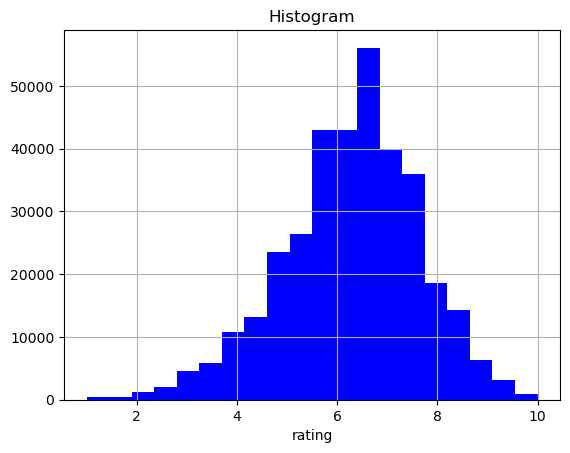

In [85]:
# Bar plot for ratings
movie_Recommender_df['averageRating'].hist(bins=20, color='blue')
plt.xlabel('rating')
plt.title('Histogram')
plt.show()

#Observations :
# We can visualize the frequency distribution of a ratings

### Univarient Analysis of Genres : 
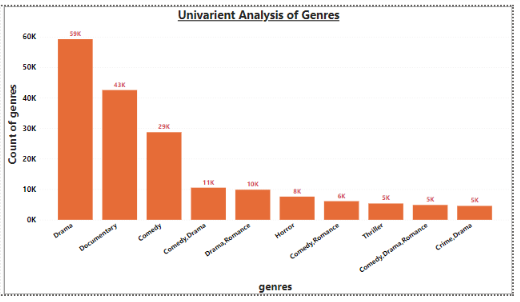

### Univarient Analysis of Ratings :
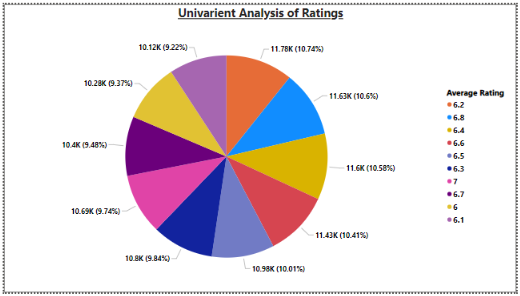

### Univarient Analysis of title type

<AxesSubplot:ylabel='titleType'>

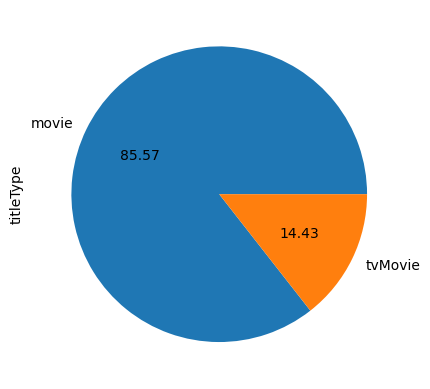

In [86]:
movie_Recommender_df['titleType'].value_counts().plot(kind='pie',autopct='%.2f')

### 2.Bivarient Analysis

### Number of movies by directors : 
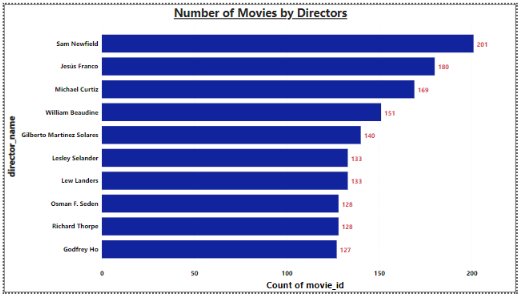

### Number of movies per decade:
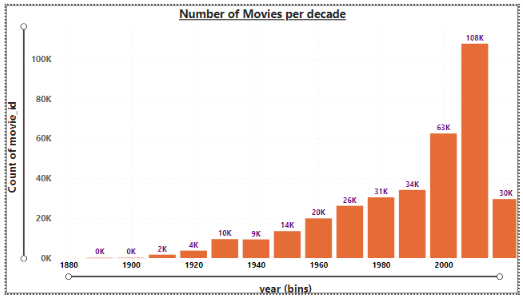

### Top 10 count of movies per genres:
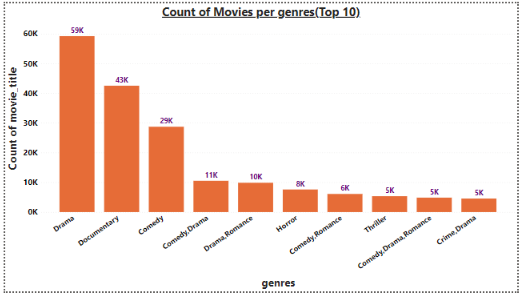    

# Model Building

# -----------------------------------------------------------------------------------------------------------

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=1000,stop_words='english')

vector = cv.fit_transform(movie_Recommender_df['combined_features']).toarray()

vector.shape

#Compute the cosine similarity matrix
cosine_sim = cosine_similarity(vector)

cosine_sim

#Function to get movie recommendations based on content
def get_recommendations(title, cosine_sim):
    idx = movie_Recommender_df[movie_Recommender_df['movieTitle'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Get top 10 recommendations
    movie_indices = [i[0] for i in sim_scores]
    return df[['genres','directorName']].iloc[movie_indices]

#Get recommendations for a given movie title
get_recommendations('The Dark Knight', cosine_sim)

# -----------------------------------------------------------------------------------------------------------

# 1. Collabrative Based

item-based collaborative filtering and hybrid recommendation systems, that can be used when user data is not available

# -----------------------------------------------------------------------------------------------------------

# 2. Popularity Based 

In [87]:
def popularity_based_recommendations(movie_Recommender_df, num_recommendations=10):

    # Load the IMDb dataset
    df = movie_Recommender_df

    # Extract the relevant features
    movies = df[['movieId', 'movieTitle', 'averageRating', 'numVotes']]

    # Compute the popularity score for each movie
    avg_rating = movies['averageRating'].mean()
    min_votes = movies['numVotes'].quantile(0.70)
    movies['popularity_score'] = (movies['numVotes'] / (movies['numVotes'] + min_votes)) * movies['averageRating'] + (min_votes / (movies['numVotes'] + min_votes)) * avg_rating
                                                                                              
    # Recommend the top-rated movies to the users
    recommendations = movies.sort_values('popularity_score', ascending=False).head(num_recommendations)['movieTitle'].tolist()

    return recommendations

## Try movie recommender-->>

In [88]:
dataset_path = movie_Recommender_df
num_recommendations = 10

recommended_movies = popularity_based_recommendations(dataset_path, num_recommendations)

print(recommended_movies)

['The Silence of Swastika', 'Threat Level Midnight: The Movie', 'The Shawshank Redemption', 'Madhi', 'The Godfather', 'Hababam Sinifi', 'Viratapura Viraagi', 'Nee Jathaga', 'Ramayana: The Legend of Prince Rama', 'Ramayana: The Legend of Prince Rama']


# -----------------------------------------------------------------------------------------------------------

# 3. Content Based

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

In [90]:

def content_based_recommendations(dataset_path, movie_title, num_recommendations=10):

    # Load the IMDb dataset
    df = movie_Recommender_df

    # Extract the relevant features
    movies = df[['movieId', 'movieTitle', 'genres', 'year']]

    # Preprocess the movie genres
    movies['genres'] = movies['genres'].apply(lambda x: x.split(','))

    # Convert the movie genres into a TF-IDF matrix
    tfidf = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
    genres_tfidf = tfidf.fit_transform(movies['genres'])

    # Train the KNN model
    knn = NearestNeighbors(n_neighbors=num_recommendations, algorithm='brute', metric='cosine')
    knn.fit(genres_tfidf)

    # Find the index of the input movie title
    title_index = movies[movies['movieTitle'] == movie_title].index[0]

    # Generate the movie recommendations
    distances, indices = knn.kneighbors(genres_tfidf[title_index], n_neighbors=num_recommendations)
    recommendations = [movies['movieTitle'][i] for i in indices.flatten()]

    return recommendations

## Try movie recommender-->>

In [91]:
dataset_path = movie_Recommender_df
movie_title = 'Avengers: Age of Ultron'  # Enter a movie title, system will show similar to that movie
num_recommendations = 9

recommended_movies = content_based_recommendations(dataset_path, movie_title, num_recommendations)

print(recommended_movies)

['Laserhawk', 'Sazer X: The Movie', 'Maze Runner: The Death Cure', 'Captain Marvel', 'Spectral', 'The Pharaoh Project', 'Captain Marvel', 'The Predator', 'Flight World War II']


# -----------------------------------------------------------------------------------------------------------

# 3. Actor Based Recoomendation

In [92]:
Actor_df_main = Actor_df_main.toPandas()
# saving a pandas dataframe into a CSV file 
Actor_df_main.to_csv(r'E:\CDAC\pgdbda\project\team_7\Final-Movie-Recommender\actor_df.csv', index=False, sep=',', encoding='utf-8', header=True)
def actor_based_recommendations(dataset_path, movie_title, num_recommendations=10):

    # Load the IMDb dataset
    df1= Actor_df_main

    # Extract the relevant features
    movies = df1[['movie_id','movie_title', 'Actor_name', 'year']]

    # Preprocess the movie genres
    movies['Actor_name'] = movies['Actor_name'].apply(lambda x: x.split(' '))

    # Convert the movie genres into a TF-IDF matrix
    tfidf = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
    genres_tfidf = tfidf.fit_transform(movies['Actor_name'])

    # Train the KNN model
    knn = NearestNeighbors(n_neighbors=num_recommendations, algorithm='brute', metric='cosine')
    knn.fit(genres_tfidf)

    # Find the index of the input movie title
    title_index = movies[movies['movie_title'] == movie_title].index[0]

    # Generate the movie recommendations
    distances, indices = knn.kneighbors(genres_tfidf[title_index], n_neighbors=num_recommendations)
    recommendations = [movies['movie_title'][i] for i in indices.flatten()]

    return recommendations

## Try movie recommender-->>

In [93]:
dataset_path = Actor_df_main
movie_title = 'Student of the Year'   # Enter a movie title, system will show similar to that movie
num_recommendations = 10

recommended_movies = actor_based_recommendations(dataset_path, movie_title, num_recommendations)

print(recommended_movies)

['Sui Dhaaga: Made in India', 'Coolie No. 1', 'Dishoom', 'Street Dancer 3D', 'October', 'Student of the Year', 'Humpty Sharma Ki Dulhania', 'Judwaa 2', 'Any Body Can Dance 2', 'Dilwale']


# -----------------------------------------------------------------------------------------------------------

# 4. Actress Based Recommendation

In [94]:
actress_df_main = actress_df_main.toPandas()
actress_df_main.to_csv(r'E:\CDAC\pgdbda\project\team_7\Final-Movie-Recommender\actress_df.csv', index=False, sep=',', encoding='utf-8', header=True)
def actress_based_recommendations(dataset_path, movie_title, num_recommendations=10):

    # Load the IMDb dataset
    df2= actress_df_main

    # Extract the relevant features
    movies = df2[['movie_id','movie_title', 'actress_name', 'year']]

    # Preprocess the movie genres
    movies['actress_name'] = movies['actress_name'].apply(lambda x: x.split(' '))

    # Convert the movie genres into a TF-IDF matrix
    tfidf = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
    genres_tfidf = tfidf.fit_transform(movies['actress_name'])

    # Train the KNN model
    knn = NearestNeighbors(n_neighbors=num_recommendations, algorithm='brute', metric='cosine')
    knn.fit(genres_tfidf)

    # Find the index of the input movie title
    title_index = movies[movies['movie_title'] == movie_title].index[0]

    # Generate the movie recommendations
    distances, indices = knn.kneighbors(genres_tfidf[title_index], n_neighbors=num_recommendations)
    recommendations = [movies['movie_title'][i] for i in indices.flatten()]

    return recommendations

### Try movie recommender-->>

In [95]:
dataset_path = actress_df_main
movie_title = 'Student of the Year'   # Enter a movie title, system will show similar to that movie
num_recommendations = 10

 
recommended_movies = actress_based_recommendations(dataset_path, movie_title, num_recommendations)

print(recommended_movies)

['2 States', 'Udta Punjab', 'Brahmastra Part One: Shiva', 'Darlings', 'Student of the Year', 'Humpty Sharma Ki Dulhania', 'Shaandaar', 'RRR (Rise Roar Revolt)', 'Badrinath Ki Dulhania', 'Highway']


In [ ]:
spark.session()